# Part 4, Topic 2: CPA on Firmware Implementation of AES

**SUMMARY**: *By now, you'll have used a DPA attack to break AES. While this method has its place in side channel attacks, it often requires a large number of traces to break AES and can suffer from additional issues like ghost peaks.*

*We've also learned in the previous lab that there is a very linear relationship between the hamming weight of the SBox output and the power consumption at that point. Instead of checking average power consumption over many traces to see if a guessed subkey is correct, we can instead check if our guessed subkey also has this linear relationship with the device's power consumption across a set of traces. Like with DPA, we'll need to repeat this measurement at each point in time along the power trace.*

*To get an objective measurement of how linear this relationship is, we'll be developing some code to calculate the Pearson correlation coefficient.*

**LEARNING OUTCOMES:**
* Developing an algorithm based on a mathematical description
* Verify that correlation can be used to break a single byte of AES
* Extend the single byte attack to the rest of the key

## Prerequisites

This notebook will build upon previous ones. Make sure you've completed the following tutorials and their prerequisites:

* ☑ Part 3 notebooks (you should be comfortable with running an attack on AES)
* ☑ Power and Hamming Weight Relationship (we'll be using information from this tutorial)

## AES Trace Capture

Our first step will be to send some plaintext to the target device and observe its power consumption during the encryption. The capture loop will be the same as in the DPA attack. This time, however, we'll only need 50 traces to recover the key, a major improvement over the last attack!

Depending what you are using, you can complete this either by:

* Capturing new traces from a physical device.
* Reading pre-recorded data from a file.

You get to choose your adventure - see the two notebooks with the same name of this, but called `(SIMULATED)` or `(HARDWARE)` to continue. Inside those notebooks you should get some code to copy into the following section, which will define the capture function.

Be sure you get the `"✔️ OK to continue!"` print once you run the cell afterwards, otherwise things will fail later on!

In [1]:
SCOPETYPE = 'CWNANO'
PLATFORM = 'CWNANO'
CRYPTO_TARGET='TINYAES128C' 
SS_VER='SS_VER_1_1'

In [2]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


INFO: Found ChipWhisperer😍


In [3]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2

Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWNANO.hex
rm -f -- simpleserial-aes-CWNANO.eep
rm -f -- simpleserial-aes-CWNANO.cof
rm -f -- simpleserial-aes-CWNANO.elf
rm -f -- simpleserial-aes-CWNANO.map
rm -f -- simpleserial-aes-CWNANO.sym
rm -f -- simpleserial-aes-CWNANO.lss
rm -f -- objdir-CWNANO/*.o
rm -f -- objdir-CWNANO/*.lst
rm -f -- simpleserial-aes.s simpleserial.s stm32f0_hal_nano.s stm32f0_hal_lowlevel.s aes.s aes-independant.s
rm -f -- simpleserial-aes.d simpleserial.d stm32f0_hal_nano.d stm32f0_hal_lowlevel.d aes.d aes-independant.d
rm -f -- simpleserial-aes.i simpleserial.i stm32f0_hal_nano.i stm32f0_hal_lowlevel.i aes.i aes-independant.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (Arch Repository) 11.2.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warr

In [4]:
cw.program_target(scope, prog, "../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5771 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5771 bytes


In [5]:
from tqdm.notebook import trange
import numpy as np

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

key, text = ktp.next()

print([hex(k) for k in key])

target.set_key(key)

N = 100
for i in trange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next()
    
trace_array = np.array(trace_array)

['0x2b', '0x7e', '0x15', '0x16', '0x28', '0xae', '0xd2', '0xa6', '0xab', '0xf7', '0x15', '0x88', '0x9', '0xcf', '0x4f', '0x3c']


Capturing traces:   0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
assert len(trace_array) == 100
print("✔️ OK to continue!")

✔️ OK to continue!


Again, let's quickly plot a trace to make sure everything looks as expected:

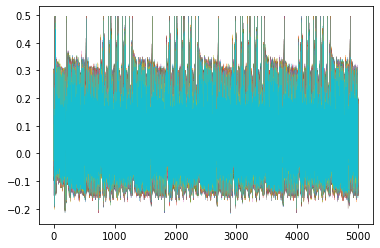

In [7]:
%matplotlib inline
import matplotlib.pylab as plt


plt.plot(trace_array.transpose(), linewidth = 0.2)
plt.show()

## AES Model and Hamming Weight

Like with the previous tutorial, we'll need to be able to easily grab what the sbox output will be for a given plaintext and key, as well as get the hamming weight of numbers between 0 and 255:

In [7]:
def aes_internal(inputdata, key):
    sbox = [
        # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
        0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
        0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
        0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
        0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
        0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
        0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
        0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
        0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
        0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
        0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
        0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
        0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
        0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
        0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
        0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
        0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
    ]
    return sbox[inputdata ^ key]

def compute_hw(n):
    return bin(n).count("1")


HW = []

for i in range(256):
    HW.append(compute_hw(i))

Verify that your model is correct:

In [8]:
assert HW[aes_internal(0xA1, 0x79)] == 3
assert HW[aes_internal(0x22, 0xB1)] == 5
print("✔️ OK to continue!")

✔️ OK to continue!


## Developing our Correlation Algorithm 

As we discussed earlier, we'll be testing how good our guess is using a measurement called the Pearson correlation coefficient, which measures the linear correlation between two datasets. 

The actual algorithm is as follows for datasets $X$ and $Y$ of length $N$, with means of $\bar{X}$ and $\bar{Y}$, respectively:

$$r = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

$cov(X, Y)$ is the covariance of `X` and `Y` and can be calculated as follows:

$$cov(X, Y) = \sum_{n=1}^{N}[(Y_n - \bar{Y})(X_n - \bar{X})]$$

$\sigma_X$ and $\sigma_Y$ are the standard deviation of the two datasets. This value can be calculated with the following equation:

$$\sigma_X = \sqrt{\sum_{n=1}^{N}(X_n - \bar{X})^2}$$

As you can see, the calulation is actually broken down pretty nicely into some smaller chunks that we can implement with some simple functions. While we could use a library to calculate all this stuff for us, being able to implement a mathematical algorithm in code is a useful skill to develop. 

To start, build the following functions:

1. `mean(X)` to calculate the mean of a dataset (the mean being `X_bar` that will be used elsewhere).
1. `std_dev(X, X_bar)` to calculate the standard deviation of a dataset. We'll need to reuse the mean for the covariance, so it makes more sense to calculate it once and pass it in to each function
1. `cov(X, X_bar, Y, Y_bar)` to calculate the covariance of two datasets. Again, we can just pass in the means we calculate for std_dev here.

**HINT: You can use `np.sum(X, axis=0)` to replace all of the $\sum$ from earlier. The argument `axis=0` will sum across columns, allowing us to use a single `mean`, `std_dev`, and `cov` call for the entire power trace**

In [9]:
# these functions can compute mean, std_dev and covariance
# with broadcasting. For example, cov() can take as inputs
# an (m, n) matrix M, the (1, n) vector with the mean values of M,
# (along columns), an (m, 1) vector V and the (1,1) vector
# with the mean value of V. The output will be a (1,n) vector containing
# the covariance between each  column of M and V.

def mean(X):
    return np.sum(X, axis = 0)/len(X)
    
def std_dev(X, X_bar):
    return np.sqrt(np.sum(np.power(X - X_bar, 2), axis = 0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X - X_bar)*(Y - Y_bar), axis = 0)


Let's quickly check to make sure everything's as expected. The following blocks will run some test vectors on your functions, confirm you get the correct answer:

In [10]:
a = np.array([[5, 3, 4, 4, 5, 6],
             [27, 2, 3, 4, 12, 6],
              [1, 3, 5, 4, 5, 6],
              [1, 2, 3, 4, 5, 6],
             ]).transpose()
a_bar = mean(a)
b = np.array([[5, 4, 3, 2, 1, 3]]).transpose()
b_bar = mean(b)

print(a_bar)
print(b_bar)

o_a = std_dev(a, a_bar)
o_b = std_dev(b, b_bar)

ab_cov = cov(a, a_bar, b, b_bar)
print(ab_cov)

print("\nCorrelation coeffs between each column of a and the vector b: \n", ab_cov/(o_a*o_b))

[4.5 9.  4.  3.5]
[3.]
[ -1.  28.  -9. -10.]

Correlation coeffs between each column of a and the vector b: 
 [-0.13483997  0.41647488 -0.71151247 -0.75592895]


In [11]:
assert (a_bar == np.array([4.5, 9., 4., 3.5])).all()
assert (b_bar == np.array([3.])).all()
assert (o_a[3] > 4.1833001 and o_a[3] < 4.1833002)
assert (o_b[0] > 3.162277 and o_b[0] < 3.162278)
assert (ab_cov == np.array([-1., 28., -9., -10.])).all()
print("✔️ OK to continue!")

✔️ OK to continue!


Now that we've got all the building blocks to our correlation function, let's see if we can put everything together and break a single byte of AES. In order to do this, let's take a closer look at what we're trying to do and the data we've got.

## Correlation Data

Remember that the general correlation formula for two datasets $X$  and $Y$ is:

$$r = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

We are going to be correlateing between a power measurment (`trace_array`) and Hamming weight of a key guess. First let's look at our power trace array:

In [12]:
print(trace_array)

[[ 0.03515625  0.20703125 -0.06640625 ...  0.15234375 -0.22265625
  -0.10546875]
 [ 0.05078125  0.21875    -0.05859375 ...  0.14453125 -0.22265625
  -0.08984375]
 [-0.23828125  0.2109375  -0.06640625 ...  0.12890625 -0.23046875
  -0.09765625]
 ...
 [ 0.12109375  0.20703125 -0.0625     ...  0.140625   -0.23828125
  -0.09765625]
 [ 0.05859375  0.2109375  -0.06640625 ...  0.13671875 -0.23046875
  -0.10546875]
 [-0.2421875   0.19921875 -0.078125   ...  0.140625   -0.21484375
  -0.08984375]]


You should have something like the following:
```python
[
    [point_0, point_1, point_2, ...], # trace 0
    [point_0, point_1, point_2, ...], # trace 1
    [point_0, point_1, point_2, ...], # trace 2
    ...
]
```

where the rows of the array are the different traces we captured and the columns of the array are the different points in those traces. The columns here will be one of the two datasets for our correlation equation. The other dataset will be the hamming weight of the SBox output, for a given *key guess* `key` of the byte we are looking at:

```python
[
      [HW[aes_internal(plaintext0[0], key[0])], # trace 0
      [HW[aes_internal(plaintext1[0], key[0])], # trace 1
      [HW[aes_internal(plaintext2[0], key[0])], # trace 2
      ...
]
```

which we'll shorten to:

```python
[
      [hw], # trace 1
      [hw], # trace 2
      [hw], # trace 3
      ...
]
```

Like with the DPA attack, we don't know where the encryption is occurring, meaning we have to repeat the correlation calculation for each column in the trace array, with the largest correlation being our best guess for where the SBox output is happening. We obviously also don't know the key (that's the thing we're trying to find!), so we'll also need to repeat the best correlation calculation for each possible value of `key[0]` (0 to 255). The key with the highest absolute correlation is our best guess for the value of the key byte.

## Correlation Attack Implementaiton

The correlation attack is basically to calculate this:

$$r = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

Where:

* $X$ is a power trace sample point
* $Y$ is an internal state guess

Remember you already defined (and tested) the functions that generate `cov(X,Y)`, and also the `std_dev(X)` ($\sigma_X$). The actual API for those functions requires to to pass in the `mean()` as well as a seperate argument (passed in for computational efficiency, since it is re-used).

### Hint: Using Vectors

We should mention a few way to improve your work.

A really nice feature of numpy is that we can do the correlation calculations across the entire trace at once (mean, std_dev, cov). That means there's no need to do:

```python
t_bar = []
for point_num in range(len(trace_array[0])):
    t_bar.append(mean(trace_array[:,point_num]))
    # and so on...

t_bar = np.array(t_bar)
```

when we can do

```python
t_bar = mean(trace_array)
```

and get the same thing back. The only caveat being that we need to make sure that the columns and rows of our arrays are the right way around (i.e. make sure your hamming weight array has 1 column and 50 rows and not the other way around). If you find it easier to construct and array one way and not the other, you can use the `.transpose()` method to swap the rows and columns.

### Finding Largest Correlation

Once you've got all your correlations for a particular key guess, you want to find the largest absolute correlation. We're taking the absolute value of the correlation here since we only care that the relation between hamming weight and the power trace is linear, not that the slope is positive or negative. `max(abs(correlations))` will do that for you.

### Enumerating Guesses

Perform this for every possible value of the key byte (aka 0 to 255) and the one with the largest correlation is your best guess for the key. It's up to you how you want to extract this information from your loop, but one way of doing it is to stick the best guess for each of your key guesses in an array. Once you've gone through all the key guesses, you can extract the best guess with `np.argmax(maxcpa)` and the correlation of that guess with `max(maxcpa)`.

### Equation to Python

We can take the earlier equation and plug in some of our Python variable names to give you a good starting point. We are using:

* $r$ = `cpaoutput`
* $X$ = `t` or `trace_array` (the average of it called `t_bar`).
* $Y$ = `hws` (the mean of it called `hws_bar`).

Our equation now looks something like this:

$$cpaoutput = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

This should almost directly convert to Python code!

In [13]:
import warnings
warnings.filterwarnings("error")

a = np.array([1,2,3,4])
b = np.array([4,3,2,0.0])

try:
    print(np.divide(a,b))
except RuntimeWarning as w:
    print(w)

divide by zero encountered in true_divide


In [14]:
from tqdm.notebook import tnrange
import warnings


# Set warnings as errors to catch divide-by-zero
# errors that can occur if ADC's output saturates
warnings.filterwarnings("error")


# we don't need to redo the mean and std dev calculations 
# for each key guess
t_bar = mean(trace_array)
t_sigma = std_dev(trace_array, t_bar)


maxcpa = np.zeros(256)
byte_to_attack = 3

err_counter = 0

for kguess in tnrange(0, 256):

    hws = np.array([[HW[aes_internal(textin[byte_to_attack], kguess)] for textin in textin_array]]).transpose()

    hws_mean = mean(hws)
    hws_sigma = std_dev(hws, hws_mean)
    
    covariances = cov(trace_array, t_bar, hws, hws_mean)
    std_dev_products = hws_sigma * t_sigma

    try:
        cpaoutput = np.divide(covariances, std_dev_products)
    except RuntimeWarning as w:
        if err_counter < 3:
            print("\n", w, "\n")
            print("A divide-by-zero error occurred because some standard deviation is exactly 0.\
                \nThis is caused by the chipwhisperer ADC's output saturating.\
                \n I'll try to recover the available information by ignoring\
                \n the corrupted points.\n")

        elif err_counter == 3:
            print("A divide-by-zero error occurred because some standard deviation is exactly 0.\
                \n I'll try to recover the available information by ignoring\
                \n the corrupted points. This warning will be suppressed from now on.\n")

        cpaoutput = np.zeros_like(covariances)

        for idx, (covariance, std_dev_product) in enumerate(zip(covariances, std_dev_products)):
            
            try:
                cpaoutput[idx] = covariance / std_dev_product
            except RuntimeWarning:
                continue

        err_counter += 1

        
    maxcpa[kguess] = np.max(np.abs(cpaoutput))
    
    
guess = np.argmax(maxcpa)
guess_corr = np.max(maxcpa)
    
print(f"Key guess for subkey {byte_to_attack}: ", hex(guess))
print(f"Correlation for subkey {byte_to_attack}: ", guess_corr)

plt.plot(maxcpa)
plt.show()

  0%|          | 0/256 [00:00<?, ?it/s]


 invalid value encountered in true_divide 

A divide-by-zero error occurred because some standard deviation is exactly 0.                
This is caused by the chipwhisperer ADC's output saturating.                
 I'll try to recover the available information by ignoring                
 the corrupted points.


 invalid value encountered in true_divide 

A divide-by-zero error occurred because some standard deviation is exactly 0.                
This is caused by the chipwhisperer ADC's output saturating.                
 I'll try to recover the available information by ignoring                
 the corrupted points.


 invalid value encountered in true_divide 

A divide-by-zero error occurred because some standard deviation is exactly 0.                
This is caused by the chipwhisperer ADC's output saturating.                
 I'll try to recover the available information by ignoring                
 the corrupted points.

A divide-by-zero error occurred because some standard d

NameError: name 'plt' is not defined

Let's make sure we've recovered the byte correctly:

  0%|          | 0/256 [00:00<?, ?it/s]


 invalid value encountered in true_divide 

A divide-by-zero error occurred because some standard deviation is exactly 0.                
This is caused by the chipwhisperer ADC's output saturating.                
 I'll try to recover the available information by ignoring                
 the corrupted points.


 invalid value encountered in true_divide 

A divide-by-zero error occurred because some standard deviation is exactly 0.                
This is caused by the chipwhisperer ADC's output saturating.                
 I'll try to recover the available information by ignoring                
 the corrupted points.


 invalid value encountered in true_divide 

A divide-by-zero error occurred because some standard deviation is exactly 0.                
This is caused by the chipwhisperer ADC's output saturating.                
 I'll try to recover the available information by ignoring                
 the corrupted points.

A divide-by-zero error occurred because some standard d

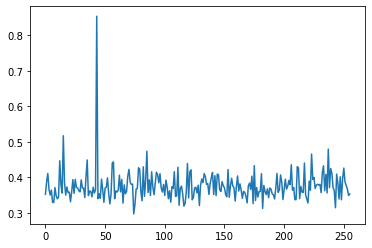

In [17]:
%matplotlib inline

import matplotlib.pylab as plt
from tqdm.notebook import tnrange
import warnings


# Set warnings as errors to catch divide-by-zero
# errors that can occur if ADC's output saturates
warnings.filterwarnings("error")


# we don't need to redo the mean and std dev calculations 
# for each key guess
t_bar = mean(trace_array)
t_sigma = std_dev(trace_array, t_bar)


maxcpa = np.zeros(256)
byte_to_attack = 0

err_counter = 0

for kguess in tnrange(0, 256):

    hws = np.array([[HW[aes_internal(textin[byte_to_attack], kguess)] for textin in textin_array]]).transpose()

    hws_mean = mean(hws)
    hws_sigma = std_dev(hws, hws_mean)
    
    covariances = cov(trace_array, t_bar, hws, hws_mean)
    std_dev_products = hws_sigma * t_sigma

    try:
        cpaoutput = np.divide(covariances, std_dev_products)
    except RuntimeWarning as w:
        if err_counter < 3:
            print("\n", w, "\n")
            print("A divide-by-zero error occurred because some standard deviation is exactly 0.\
                \nThis is caused by the chipwhisperer ADC's output saturating.\
                \n I'll try to recover the available information by ignoring\
                \n the corrupted points.\n")

        elif err_counter == 3:
            print("A divide-by-zero error occurred because some standard deviation is exactly 0.\
                \n I'll try to recover the available information by ignoring\
                \n the corrupted points. This warning will be suppressed from now on.\n")

        cpaoutput = np.zeros_like(covariances)

        for idx, (covariance, std_dev_product) in enumerate(zip(covariances, std_dev_products)):
            
            try:
                cpaoutput[idx] = covariance / std_dev_product
            except RuntimeWarning:
                continue

        err_counter += 1

        
    maxcpa[kguess] = np.max(np.abs(cpaoutput))
    
    
guess = np.argmax(maxcpa)
guess_corr = np.max(maxcpa)
    
print(f"Key guess for subkey {byte_to_attack}: ", hex(guess))
print(f"Correlation for subkey {byte_to_attack}: ", guess_corr)

print(np.arange(5000)[cpaoutput == 0.0])

plt.plot(maxcpa)
plt.show()

In [18]:
assert guess == 0x2b
print("✔️ OK to continue!")

✔️ OK to continue!


To break the rest of the key, simply repeat the attack for the rest of the bytes of the key. Don't forget to update your code from above to use the correct byte of the plaintext!

In [21]:
from tqdm.notebook import tnrange
import warnings


# Set warnings as errors to catch divide-by-zero
# errors that can occur if ADC's output saturates
warnings.filterwarnings("error")


# we don't need to redo the mean and std dev calculations 
# for each key guess
t_bar = mean(trace_array)
t_sigma = std_dev(trace_array, t_bar)

bestguess = []
guess_corr = []
err_counter = 0

for byte_to_attack in tnrange(16, desc = "Performing attack..."):

    maxcpa = np.zeros(256)


    for kguess in range(256):

        hws = np.array([[HW[aes_internal(textin[byte_to_attack], kguess)] for textin in textin_array]]).transpose()

        hws_mean = mean(hws)
        hws_sigma = std_dev(hws, hws_mean)
        
        covariances = cov(trace_array, t_bar, hws, hws_mean)
        std_dev_products = hws_sigma * t_sigma

        try:
            cpaoutput = np.divide(covariances, std_dev_products)
        except RuntimeWarning:
            if err_counter < 1:
                print("A divide-by-zero error occurred because some standard deviation is exactly 0.\
                    \nThis is caused by the chipwhisperer ADC's output saturating.\
                    \n I'll try to recover the available information by ignoring\
                    \n the corrupted points.\n")

            elif err_counter == 1:
                print("A divide-by-zero error occurred because some standard deviation is exactly 0.\
                    \n I'll try to recover the available information by ignoring\
                    \n the corrupted points. This warning will be suppressed from now on.\n")

            cpaoutput = np.zeros_like(covariances)

            for idx, (covariance, std_dev_product) in enumerate(zip(covariances, std_dev_products)):
                
                try:
                    cpaoutput[idx] = covariance / std_dev_product
                except RuntimeWarning:
                    continue

            err_counter += 1

            
        maxcpa[kguess] = np.max(np.abs(cpaoutput))
        
        
    bestguess.append(np.argmax(maxcpa))
    guess_corr.append(np.max(maxcpa))
        

print("\nSubkey\t\tKey guess\tCorrelation")
for subk, (bg, gc) in enumerate(zip(bestguess, guess_corr)):
    print(f"{subk}\t\t{hex(bg)}\t\t{gc}")



Performing attack...:   0%|          | 0/16 [00:00<?, ?it/s]


 invalid value encountered in true_divide 

A divide-by-zero error occurred because some standard deviation is exactly 0.                    
This is caused by the chipwhisperer ADC's output saturating.                    
 I'll try to recover the available information by ignoring                    
 the corrupted points.

A divide-by-zero error occurred because some standard deviation is exactly 0.                    
 I'll try to recover the available information by ignoring                    
 the corrupted points. This warning will be suppressed from now on.


Subkey		Key guess	Correlation
0		0x2b		0.854111863643399
1		0x7e		0.8613567628518172
2		0x15		0.8406867124220775
3		0x16		0.9105926126690848
4		0x28		0.8677580112655592
5		0xae		0.8916654133586971
6		0xd2		0.8070023941265405
7		0xa6		0.8432127444170037
8		0xab		0.8810205225382638
9		0xf7		0.9122335748940441
10		0x15		0.8709718205627012
11		0x88		0.892729756989415
12		0x9		0.8085205545768862
13		0xcf		0.8933812299551476
14	

With one final check to make sure you've got the correct key:

In [ ]:
for bnum in range(16):
    assert bestguess[bnum] == key[bnum], \
    "Byte {} failed, expected {:02X} got {:02X}".format(bnum, key[bnum], bestguess[bnum])
print("✔️ OK to continue!")

We're done! There's actually a lot of room to expand on this attack:

1. Currently, the loop needs to go through all the traces before it can return a correlation. This isn't too bad for a short attack, for a much longer one (think 10k+ traces) we won't get any feedback from the attack until it's finished. Also, if we didn't capture enough traces for the attack, the entire analysis calculation needs to be repeated! Instead of using the original correlation equation, we can instead use an equivalent "online" version that can be easily updated with more traces: $$r_{i,j} = \frac{D\sum_{d=1}^{D}h_{d,i}t_{d,j}-\sum_{d=1}^{D}h_{d,i}\sum_{d=1}^{D}t_{d,j}}{\sqrt{((\sum_{d=1}^Dh_{d,i})^2-D\sum_{d=1}^Dh_{d,i}^2)-((\sum_{d=1}^Dt_{d,j})^2-D\sum_{d=1}^Dh_{d,j}^2)}}$$
where

| **Equation** | **Python Variable** | **Value**  | 
|--------------|---------------------|------------|
|  d           |       tnum          | trace number |
|  i           |       kguess        | subkey guess |
| j | j index trace point | sample point in trace |
| h | hypint | guess for power consumption | 
| t | traces | traces | 

2. There's a lot more we can learn from the attack other than the key. For example, we could plot how far away the correct key guess is from the top spot (called the partial guessing entropy or PGE) vs. how many traces we used, giving us a better idea of how many traces we needed to actually recover the correct key. We also might want to plot how correlation for a given key guess changes over time.

This "online" correlation equation is the one that the subject of the next tutorial, ChipWhisperer Analyzer, actually uses. It also provides functions and methods for gathering and plotting some interesting statistics.

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>